# Evaluation Analysis

This notebook analyses the results produced by RegressionScholar. It loads `evaluation_results.json` and produces publication-quality figures and tables for retrieval and generation evaluation.

In [4]:
# Cell 2: Imports and results loader
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Optional interactive plotting
try:
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

# Robustly locate evaluation_results.json by searching up from the current working directory
def find_file_upwards(filename: str, start: Path = Path.cwd(), max_depth: int = 6) -> Path | None:
    p = start
    for _ in range(max_depth + 1):
        candidate = p / filename
        if candidate.exists():
            return candidate
        if p.parent == p:
            break
        p = p.parent
    return None

RESULTS_FILE = find_file_upwards('evaluation_results.json', start=Path.cwd(), max_depth=6)
if RESULTS_FILE is None:
    raise FileNotFoundError('evaluation_results.json not found. Run src/evaluation.py from the project root to generate it.')

with open(RESULTS_FILE, 'r', encoding='utf-8') as f:
    results = json.load(f)

# Normalize retrieval results into a DataFrame
retrieval = results.get('retrieval', {})
retrieval_rows = []
for k_key, metrics in retrieval.items():
    k = int(k_key.split('=')[-1])
    retrieval_rows.append({'k': k, 'avg_recall': metrics.get('avg_recall', 0), 'avg_precision': metrics.get('avg_precision', 0), 'avg_mrr': metrics.get('avg_mrr', 0), 'num_queries': metrics.get('num_queries', 0)})
retrieval_df = pd.DataFrame(retrieval_rows).sort_values('k')

# Generation results as DataFrame
generation = results.get('generation', [])
if generation:
    gen_df = pd.DataFrame(generation)
else:
    gen_df = pd.DataFrame(columns=['question_id', 'question', 'concept_coverage', 'has_citations', 'word_count'])

print('Loaded results:')
print(f"Retrieval entries: {len(retrieval_df)}")
print(f"Generation entries: {len(gen_df)}")

Loaded results:
Retrieval entries: 3
Generation entries: 5


## Retrieval Analysis

Plot recall, precision and MRR across k values and examine trade-offs.

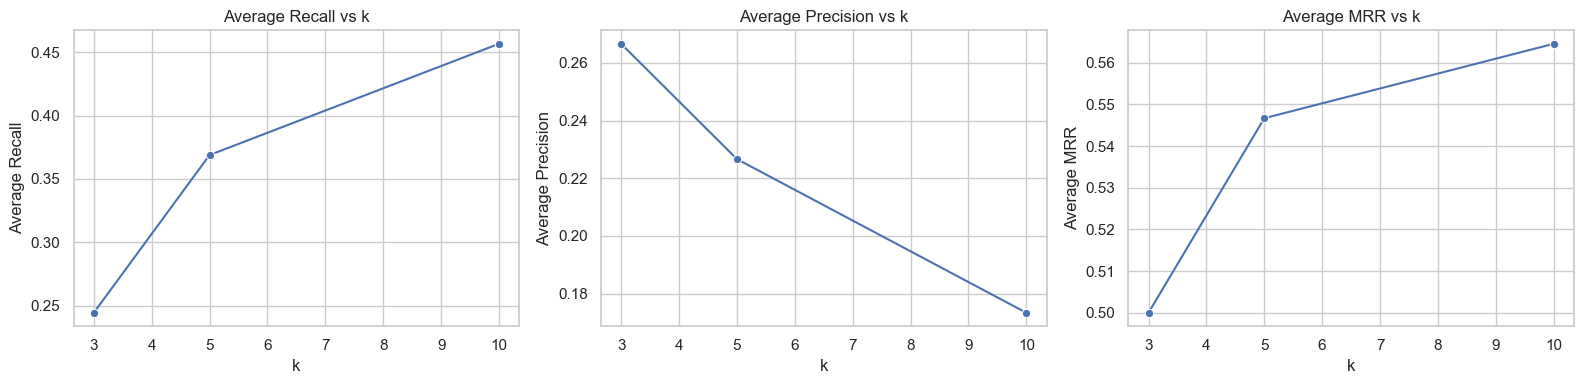

In [5]:
# Plot retrieval metrics
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.lineplot(data=retrieval_df, x='k', y='avg_recall', marker='o', ax=ax[0])
ax[0].set_title('Average Recall vs k')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Average Recall')

sns.lineplot(data=retrieval_df, x='k', y='avg_precision', marker='o', ax=ax[1])
ax[1].set_title('Average Precision vs k')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Average Precision')

sns.lineplot(data=retrieval_df, x='k', y='avg_mrr', marker='o', ax=ax[2])
ax[2].set_title('Average MRR vs k')
ax[2].set_xlabel('k')
ax[2].set_ylabel('Average MRR')

plt.tight_layout()
plt.show()

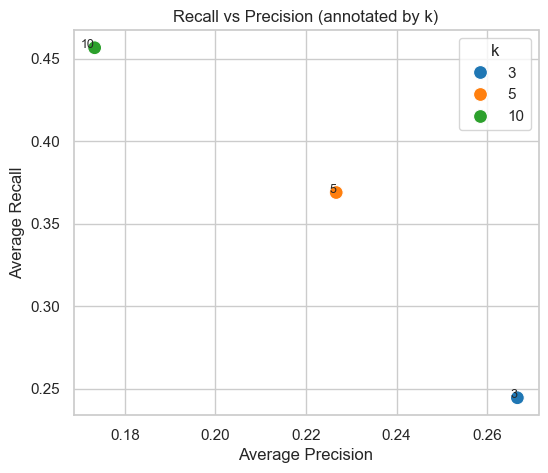

In [6]:
# Recall vs Precision trade-off plot (merged view)
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=retrieval_df, x='avg_precision', y='avg_recall', hue='k', s=100, palette='tab10', ax=ax)
for _, r in retrieval_df.iterrows():
    ax.text(r['avg_precision'], r['avg_recall'], str(int(r['k'])), fontsize=9, ha='right')
ax.set_title('Recall vs Precision (annotated by k)')
ax.set_xlabel('Average Precision')
ax.set_ylabel('Average Recall')
plt.show()

### Retrieval: best/worst queries
Identify queries with the best and worst retrieval results (requires the original per-query metrics in `evaluation_results.json`).

In [7]:
# If the results include per-query data, try to surface best/worst retrievals
# generation array may contain question-level metrics; attempt to sort by concept_coverage or other fields
if not gen_df.empty:
    best = gen_df.sort_values('concept_coverage', ascending=False).head(3)
    worst = gen_df.sort_values('concept_coverage', ascending=True).head(3)
    display(best[['question_id', 'question', 'concept_coverage', 'has_citations']])
    display(worst[['question_id', 'question', 'concept_coverage', 'has_citations']])
else:
    print('No generation details available to rank questions.')

,question_id,question,concept_coverage,has_citations
2,3,What is the bias-variance tradeoff?,1.000000,True
0,1,What is ridge regression?,0.666667,True
1,2,Compare ridge and LASSO,0.666667,True


,question_id,question,concept_coverage,has_citations
3,4,When should I use LASSO vs ridge regression?,0.333333,True
0,1,What is ridge regression?,0.666667,True
1,2,Compare ridge and LASSO,0.666667,True


## Generation Analysis

Analyse concept coverage, citation rate and answer length distribution.

C:\Users\ramse\AppData\Local\Temp\ipykernel_11648\3814758464.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cov, x='category', y='concept_coverage', palette='muted', ax=ax)


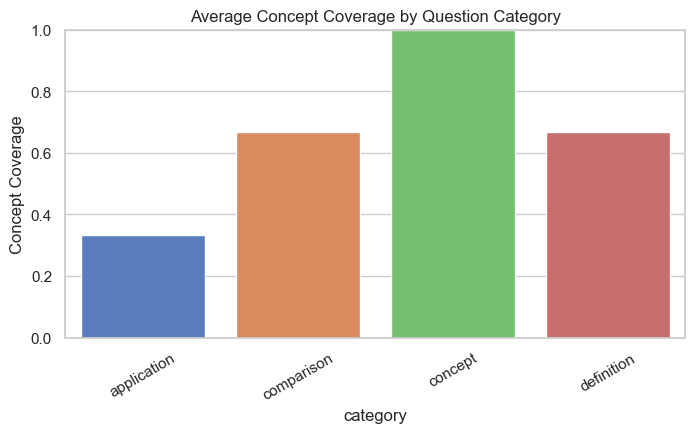

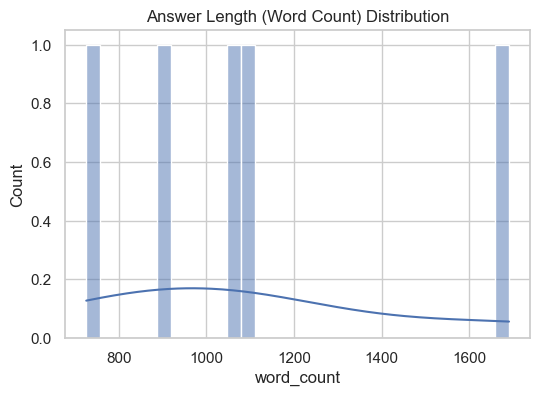

Citation rate: 100.00%


In [8]:
# Concept coverage by category
if not gen_df.empty:
    # If category is present, group by it; otherwise plot overall distribution
    if 'category' in gen_df.columns:
        cov = gen_df.groupby('category')['concept_coverage'].mean().reset_index()
        fig, ax = plt.subplots(figsize=(8,4))
        sns.barplot(data=cov, x='category', y='concept_coverage', palette='muted', ax=ax)
        ax.set_title('Average Concept Coverage by Question Category')
        ax.set_ylabel('Concept Coverage')
        ax.set_ylim(0,1)
        plt.xticks(rotation=30)
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,4))
        sns.histplot(x=gen_df['concept_coverage'], bins=20, kde=True, ax=ax)
        ax.set_title('Concept Coverage Distribution')
        plt.show()

    # Word count distribution
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(x=gen_df['word_count'], bins=30, kde=True, ax=ax)
    ax.set_title('Answer Length (Word Count) Distribution')
    plt.show()

    # Citation rate
    citation_rate = gen_df['has_citations'].mean()
    print(f'Citation rate: {citation_rate:.2%}')
else:
    print('No generation results to analyse.')

## Deep-dive Examples

Show a few best and worst answers with analysis.

In [9]:
# Show examples (best/worst)
if not gen_df.empty:
    try:
        print('\n' + '='*80)
        print('BEST PERFORMING EXAMPLES')
        print('='*80)
        for _, row in best.iterrows():
            print('\n' + '-'*80)
            print(f"Question ID: {row['question_id']}")
            print(f"Question: {row['question']}")
            print(f"Concept coverage: {row['concept_coverage']:.2%}")
            print(f"\nAnswer preview:")
            print(row.get('answer_preview', 'No preview available'))
        
        print('\n' + '='*80)
        print('WORST PERFORMING EXAMPLES')
        print('='*80)
        for _, row in worst.iterrows():
            print('\n' + '-'*80)
            print(f"Question ID: {row['question_id']}")
            print(f"Question: {row['question']}")
            print(f"Concept coverage: {row['concept_coverage']:.2%}")
            print(f"\nAnswer preview:")
            print(row.get('answer_preview', 'No preview available'))
            
    except NameError:
        print('Best/worst examples not available; ensure generation analysis ran and produced metrics.')
else:
    print('No generation examples to show.')


BEST PERFORMING EXAMPLES

--------------------------------------------------------------------------------
Question ID: 3
Question: What is the bias-variance tradeoff?
Concept coverage: 100.00%

Answer preview:
The bias-variance tradeoff describes a fundamental dilemma in statistical learning and regression analysis, where the goal is to build models that generalize well to unseen data by minimizing the "exp...

--------------------------------------------------------------------------------
Question ID: 1
Question: What is ridge regression?
Concept coverage: 66.67%

Answer preview:
Ridge regression is a statistical technique that provides an alternative estimator to the Ordinary Least Squares (OLS) estimator, particularly useful when dealing with multicollinearity, ill-condition...

--------------------------------------------------------------------------------
Question ID: 2
Question: Compare ridge and LASSO
Concept coverage: 66.67%

Answer preview:
Ridge and LASSO (Least Absolute 